# Node-centric expression models (NCEM)

Authors: [Anna Schaar](https://twitter.com/annacschaar), [David Fischer](https://twitter.com/davidsebfischer)

This tutorial shows how to leverage NCEM to understand cell communication in spatial graphs of cells. We will introduce several concepts also mentioned in our preprint [Learning cell communication from spatial graphs of cells](https://www.biorxiv.org/content/10.1101/2021.07.11.451750v1) (Fischer, Schaar, Theis, 2021).

![title](https://raw.githubusercontent.com/theislab/ncem/main/docs/_static/img/concept.png)

This notebook uses spatial data available in :mod:`squidpy.datasets` that has been pre-processed (and pre-formatted). More information on how to store spatial data in :class:`anndata.AnnData` can be found in the `squidpy` tutorial or in the documentation.

## Imports
We start by loading all packages used in this tutorial. NCEM can be installed with `pip install ncem` which automatically loads all required dependencies.

In [ ]:
#!pip install ncem

In [1]:
import ncem as nc
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import squidpy as sq

sc.settings.set_figure_params(dpi=80)

import warnings
warnings.filterwarnings("ignore")

In [2]:
sc.logging.print_header()
print(f"ncem=={nc.__version__}")

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.1 pandas==1.4.3 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.9.11 louvain==0.7.1 pynndescent==0.5.7
ncem==0.1.4


In this tutorial, we mainly focus on the linear NCEM interaction model and we will show how to use the `customLoader` class to feed any dataset into ncem. 

In [3]:
from ncem.interpretation import InterpreterInteraction
from ncem.data import get_data_custom, customLoader

## Dataset

This tutorial runs on a pre-processed MIBI-TOF dataset from Hartmann et al. which can be called fram :mod:`sq.datasets` which has been subsetted to three images. For details on how it was pre-processed, please refer to the original paper. The subset of the data we consider here comprises three biopsies colorectal carcinoma biopsies from different donors, where MIBI-TOF was used to measure single-cell metabolic profiles. 

NCEM can be run on subsets of images as well as the complete dataset depending on the analysis workflow and goal. 

In [4]:
ad = sq.datasets.mibitof()

In [5]:
ad

AnnData object with n_obs × n_vars = 3309 × 36
    obs: 'row_num', 'point', 'cell_id', 'X1', 'center_rowcoord', 'center_colcoord', 'cell_size', 'category', 'donor', 'Cluster', 'batch', 'library_id'
    var: 'mean-0', 'std-0', 'mean-1', 'std-1', 'mean-2', 'std-2'
    uns: 'Cluster_colors', 'batch_colors', 'neighbors', 'spatial', 'umap'
    obsm: 'X_scanorama', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

In [6]:
ad.obs.Cluster.value_counts()

Tcell_CD4        799
Epithelial       746
Imm_other        488
Tcell_CD8        464
Fibroblast       270
Myeloid_CD68     259
Myeloid_CD11c    168
Endothelial      115
Name: Cluster, dtype: int64

As a next step, we now call the NCEM interpreter class for interaction models. The :class:`InterpreterInteraction()` calls a linear model that predicts gene expression states from a graph of categorical cell type labels. This model is trailored to find putative sender-receiver dependencies at intermediate length scales. 

In [7]:
ncem = InterpreterInteraction()

In [8]:
ad.obs

,row_num,point,cell_id,X1,center_rowcoord,center_colcoord,cell_size,category,donor,Cluster,batch,library_id
3034-0,3086,23,2,60316.0,269.0,7.0,408.0,carcinoma,21d7,Epithelial,0,point23
3035-0,3087,23,3,60317.0,294.0,6.0,408.0,carcinoma,21d7,Epithelial,0,point23
3036-0,3088,23,4,60318.0,338.0,4.0,304.0,carcinoma,21d7,Imm_other,0,point23
3037-0,3089,23,6,60320.0,372.0,6.0,219.0,carcinoma,21d7,Myeloid_CD11c,0,point23
3038-0,3090,23,8,60322.0,417.0,5.0,303.0,carcinoma,21d7,Myeloid_CD11c,0,point23
...,...,...,...,...,...,...,...,...,...,...,...,...
47342-2,48953,16,1103,2779.0,143.0,1016.0,283.0,carcinoma,90de,Fibroblast,2,point16
47343-2,48954,16,1104,2780.0,814.0,1017.0,147.0,carcinoma,90de,Fibroblast,2,point16
47344-2,48955,16,1105,2781.0,874.0,1018.0,142.0,carcinoma,90de,Imm_other,2,point16
47345-2,48956,16,1106,2782.0,257.0,1019.0,108.0,carcinoma,90de,Fibroblast,2,point16


**Task 1**: Load your spatial AnnData object and compare it to the object extracted from squidpy? Where are your cell types stores? Do you have spatial coordinates?

The NCEM package incldues several different data loader classes that can be called after downloading the respective datasets from the original publication. In this tutorial, we will show how to use the :class:`customLoader` that generates a NCEM data object from an :class:`anndata.AnnData` object. The data needs to have cell type annotation stored in `.obs` as categorical cell types are required to run all NCEMs. Additionally, one can provide columns in `.obs` that specify the patient and the library identifier. The dataset we are using here has both donor as well as library id information. 

According to the original publication by Hartmann et al., the dataset has a resolution of 400 x 400 $\mu m$ over 1024 x 1024 pixels where the unit of the spatial coordinates in the dataset are given in pixels. NCEM functions on this same unit as provided by the spatial information. We showed that cells communicate at intermediate length scales, for this reason we select the resolution of potential interactions as 52 pixels. This translates to approximately 20 $\mu m$ which matches the distance of the computationally identified tumor–immune border according to Hartmann et al.

In [9]:
ncem.data = customLoader(
    adata=ad, cluster='Cluster', patient='donor', library_id='library_id', radius=52
)
get_data_custom(interpreter=ncem)

Loading data from raw files
registering celldata
collecting image-wise celldata
adding graph-level covariates


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.43it/s]

Loaded 3 images with complete data from 2 patients over 3309 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 9.969315
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 3309 cells out of 3 images from 2 patients.
Test dataset: 330 cells out of 3 images from 2 patients.
Training dataset: 2695 cells out of 3 images from 2 patients.
Validation dataset: 298 cells out of 3 images from 2 patients. 



0.0
1.0
10.132646043608094
131.2417658869953
1076.3813154563659


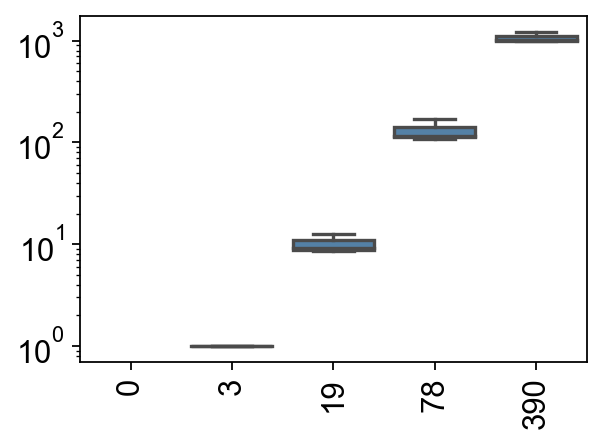

In [10]:
# node degrees for different resolutions
ncem.data.plot_degree_vs_dist(
    max_distances=[0, 10, 50, 200, 1000],
    lateral_resolution=400/1024,
)

**Task 2**: Load your data into ncem and inspect the node degrees for different distances. Are spatial coordinates given in pixels or micrometers?

## Variance decomposition

NCEM relates intra cell type variance to niche information. We, therefore, compute the image-wise variance decomposition in the data. For the shown dataset, we inspect a intra cell type variance of ~ 65 %. Usually, variance decomposition is calculated on the raw data, so we just show this here for completeness. In the NCEM preprint, we evaluated the variance decomposition of the MIBI TOF – cancer dataset from Hartmann et al. on all images and the mean intra cell type variance was 20%, mean inter cell type variance 10% and mean gene variance: 70%. 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.82it/s]


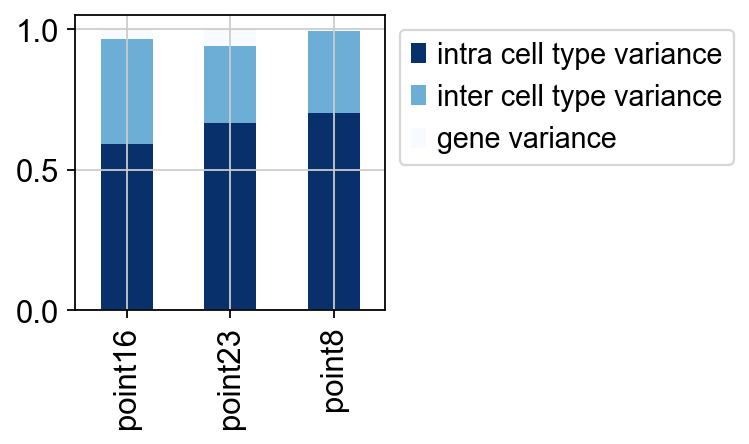

In [11]:
var_decomp = ncem.data.compute_variance_decomposition()
ncem.data.variance_decomposition(var_decomp, figsize=(5,3))

In [12]:
var_decomp.mean(axis=0)[['intra cell type variance', 'inter cell type variance', 'gene variance']]

intra cell type variance    0.653940
inter cell type variance    0.312406
gene variance               0.033654
dtype: float32

**Task 3**: Decompose the variance of your dataset? What do you inspect? Which normalization was applied to your dataset before?

## Cell heterogeneity attributed to niche composition

NCEM provides several analysis tools that help to understand niche composition and putative sender-receiver dependencies. We first compute a cluster enrichment analysis on the data on CD8 T cells. This analysis can be performed on any cell type present in the dataset.

The cluster enrichment is calculated with a Fisher’s exact test. Each contingency table is composed of two categorical variables. The first variable describes the binary assignment of cells in one specific CD8 T cell sub-cluster. The second variable describes the presence of a specific source cell type in their neighborhood.

In [13]:
adata_img, adata, log_pval, fold_change = ncem.data.compute_cluster_enrichment(
    image_key=['point16', 'point23', 'point8'],
    target_cell_type='Tcell_CD8',
    clip_pvalues=-5,
    n_neighbors=22,
    n_pcs=None,
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.18it/s]


n cells:  464
Tcell_CD8 0    145
Tcell_CD8 1    117
Tcell_CD8 2     79
Tcell_CD8 3     69
Tcell_CD8 4     54
Name: Tcell_CD8 substates, dtype: int64


The method found five CD8 T cells substates across three images. 

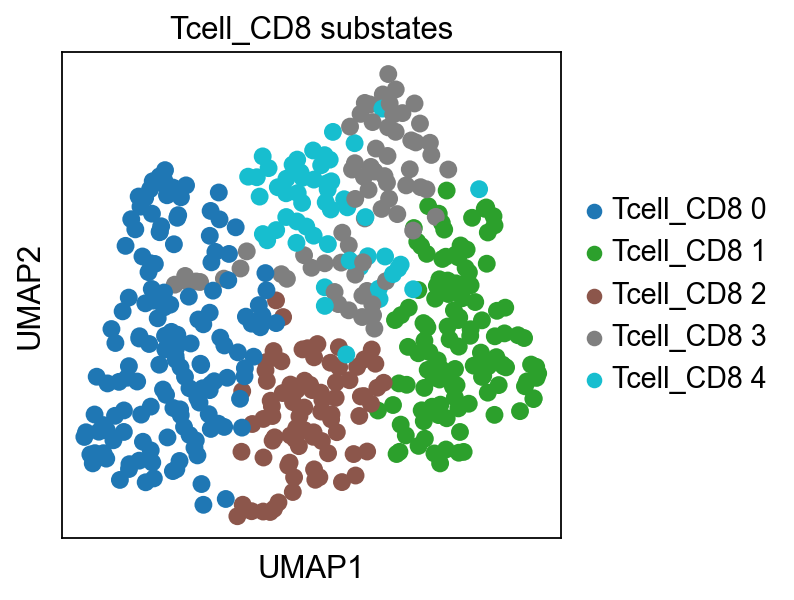

In [14]:
sc.pl.umap(adata, color='Tcell_CD8 substates', palette='tab10')

 In most cases, it is helpful to inspect the spatial allocation of the calculated substates. We find that `Tcell_CD8 1` is primarily located closed to (malignant) epithelial cells. Whereas, `Tcell_CD8 0` seems to be located further away from epithelial cells. 

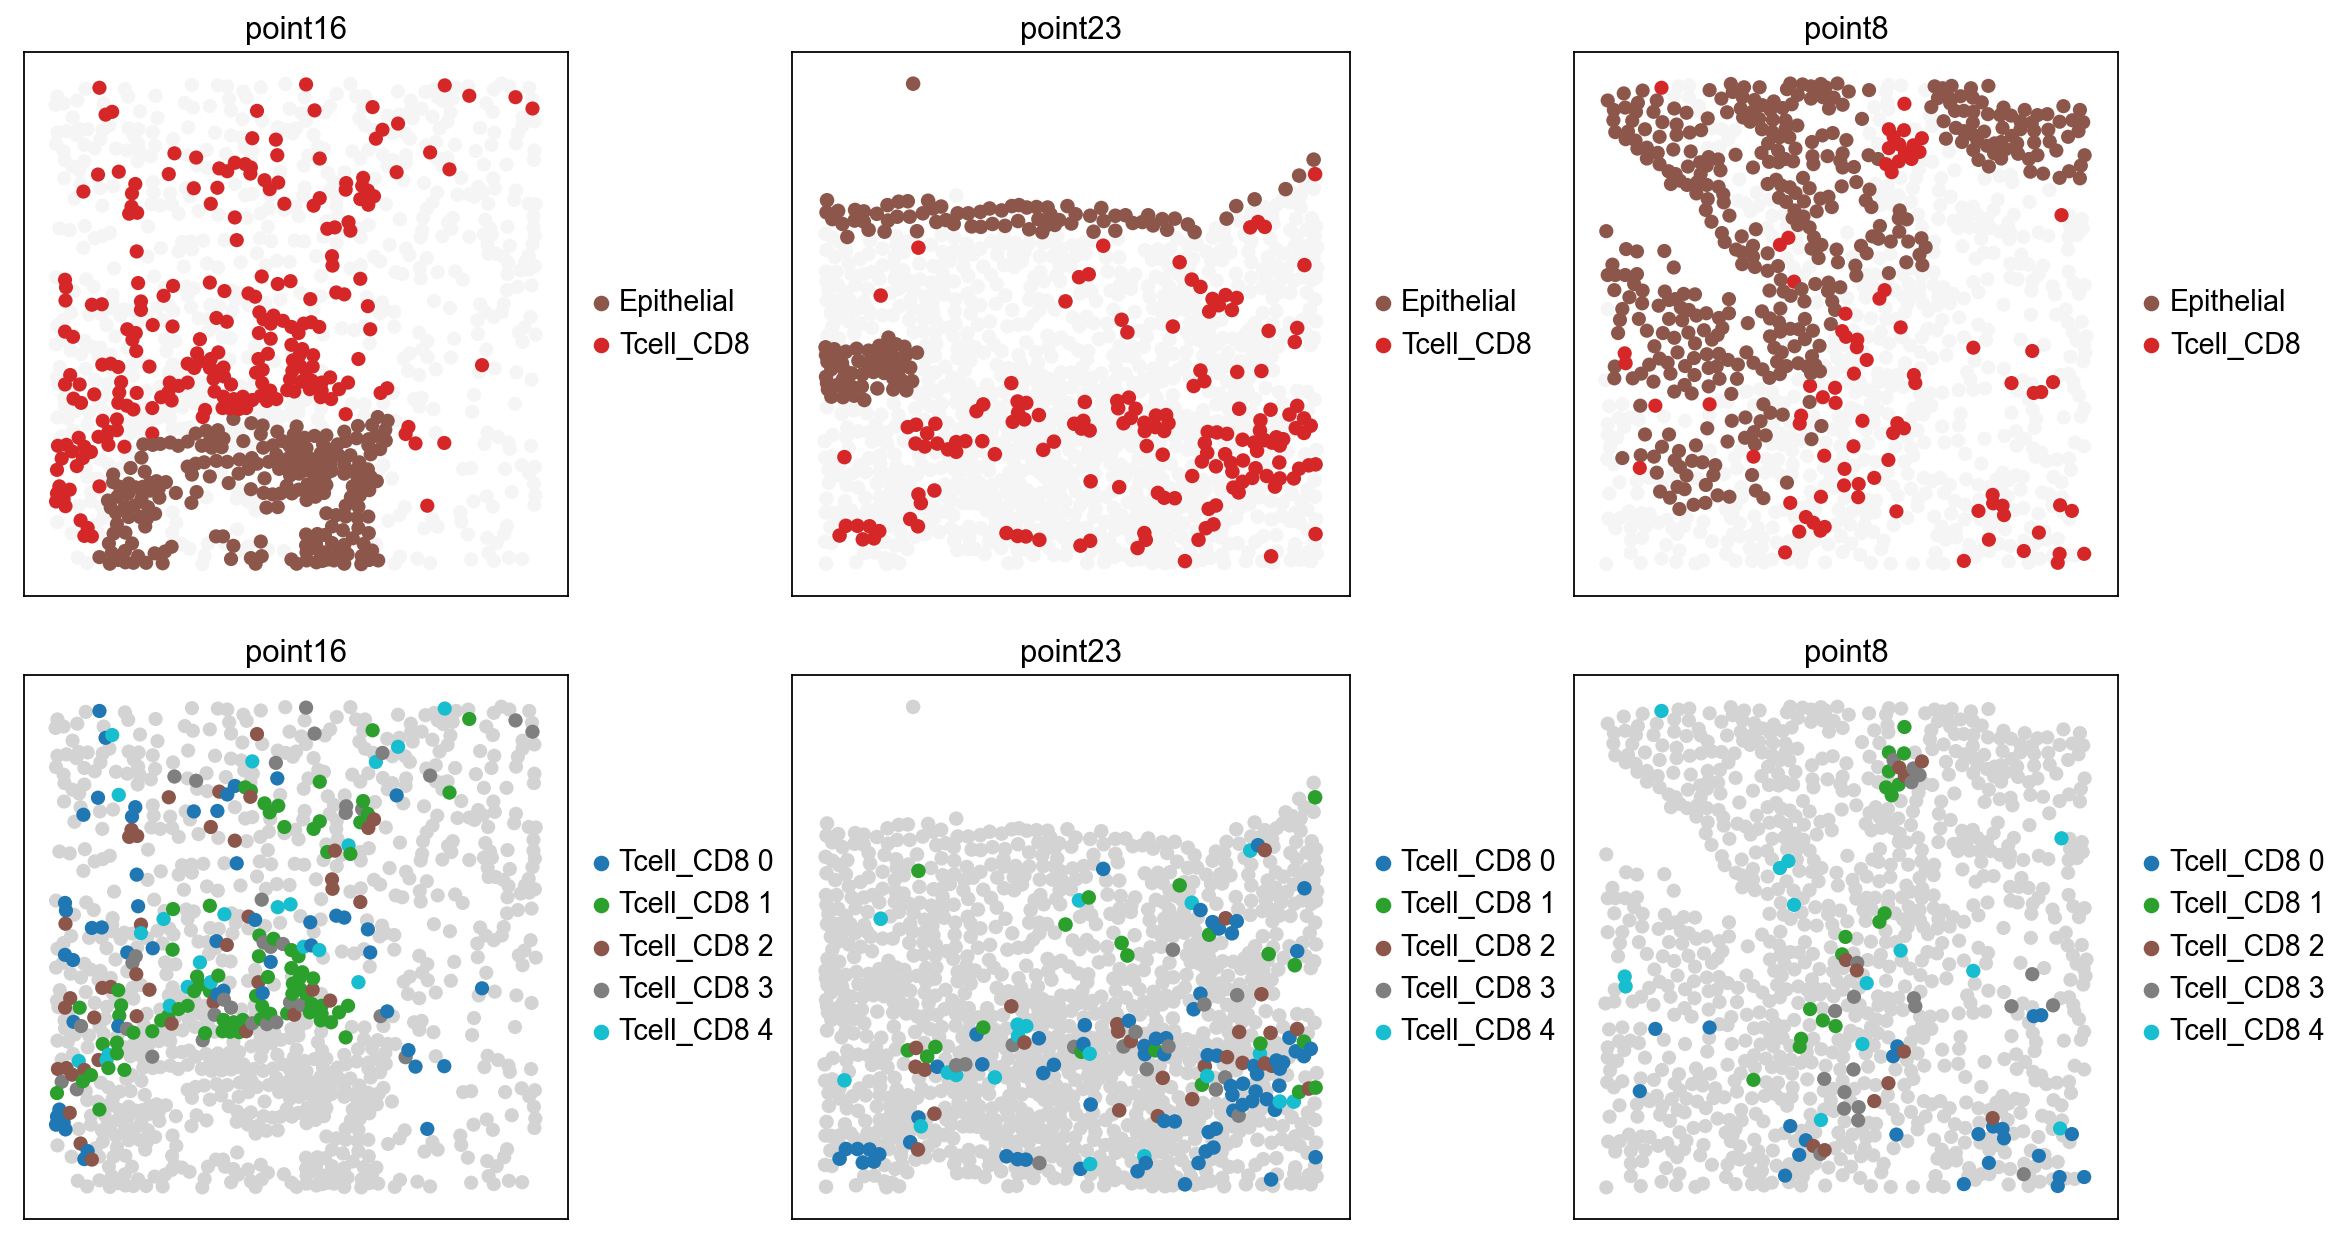

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
ax = ax.ravel()
for i, k in enumerate(['point16', 'point23', 'point8']):
    
    temp_adata = adata_img[adata_img.obs['library_id'] == k].copy()
    
    sc.pl.spatial(
        temp_adata,
        spot_size=30,
        ax=ax[i],
        show=False,
        na_color='whitesmoke',
        title=''
    )
    sc.pl.spatial(
        temp_adata[temp_adata.obs.Cluster.isin(['Epithelial', 'Tcell_CD8'])].copy(),
        color='Cluster',
        spot_size=30,
        ax=ax[i],
        show=False,
        title=k,
        palette={'Epithelial': '#8c564b', 'Tcell_CD8': '#d62728'}
    )
    
    sc.pl.spatial(
        adata_img[adata_img.obs.library_id == k].copy(),
        spot_size=30,
        ax=ax[i+3],
        show=False,
        title=''
    )
    sc.pl.spatial(
        adata[adata.obs.library_id == k].copy(),
        color='Tcell_CD8 substates',
        spot_size=30,
        ax=ax[i+3],
        show=False,
        title=k,
        palette='tab10'
    )
    
    ax[i].invert_yaxis()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i+3].invert_yaxis()
    ax[i+3].set_xlabel('')
    ax[i+3].set_ylabel('')
plt.tight_layout()
plt.show()

We can quantify this, by computing the actual $\log_{10}$-FDR corrected p-values and the fold change of putative sender-receiver dependencies.

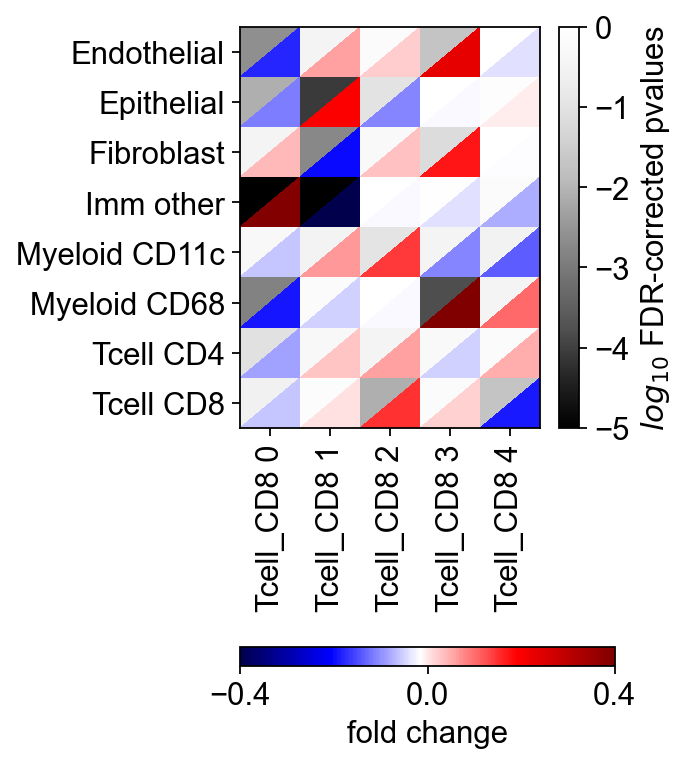

In [16]:
ncem.data.cluster_enrichment(
    pvalues=log_pval, 
    fold_change=fold_change,
    pad=0.3,
    linspace=(-0.4, 0.4, 3),
    figsize=(3,6)
)

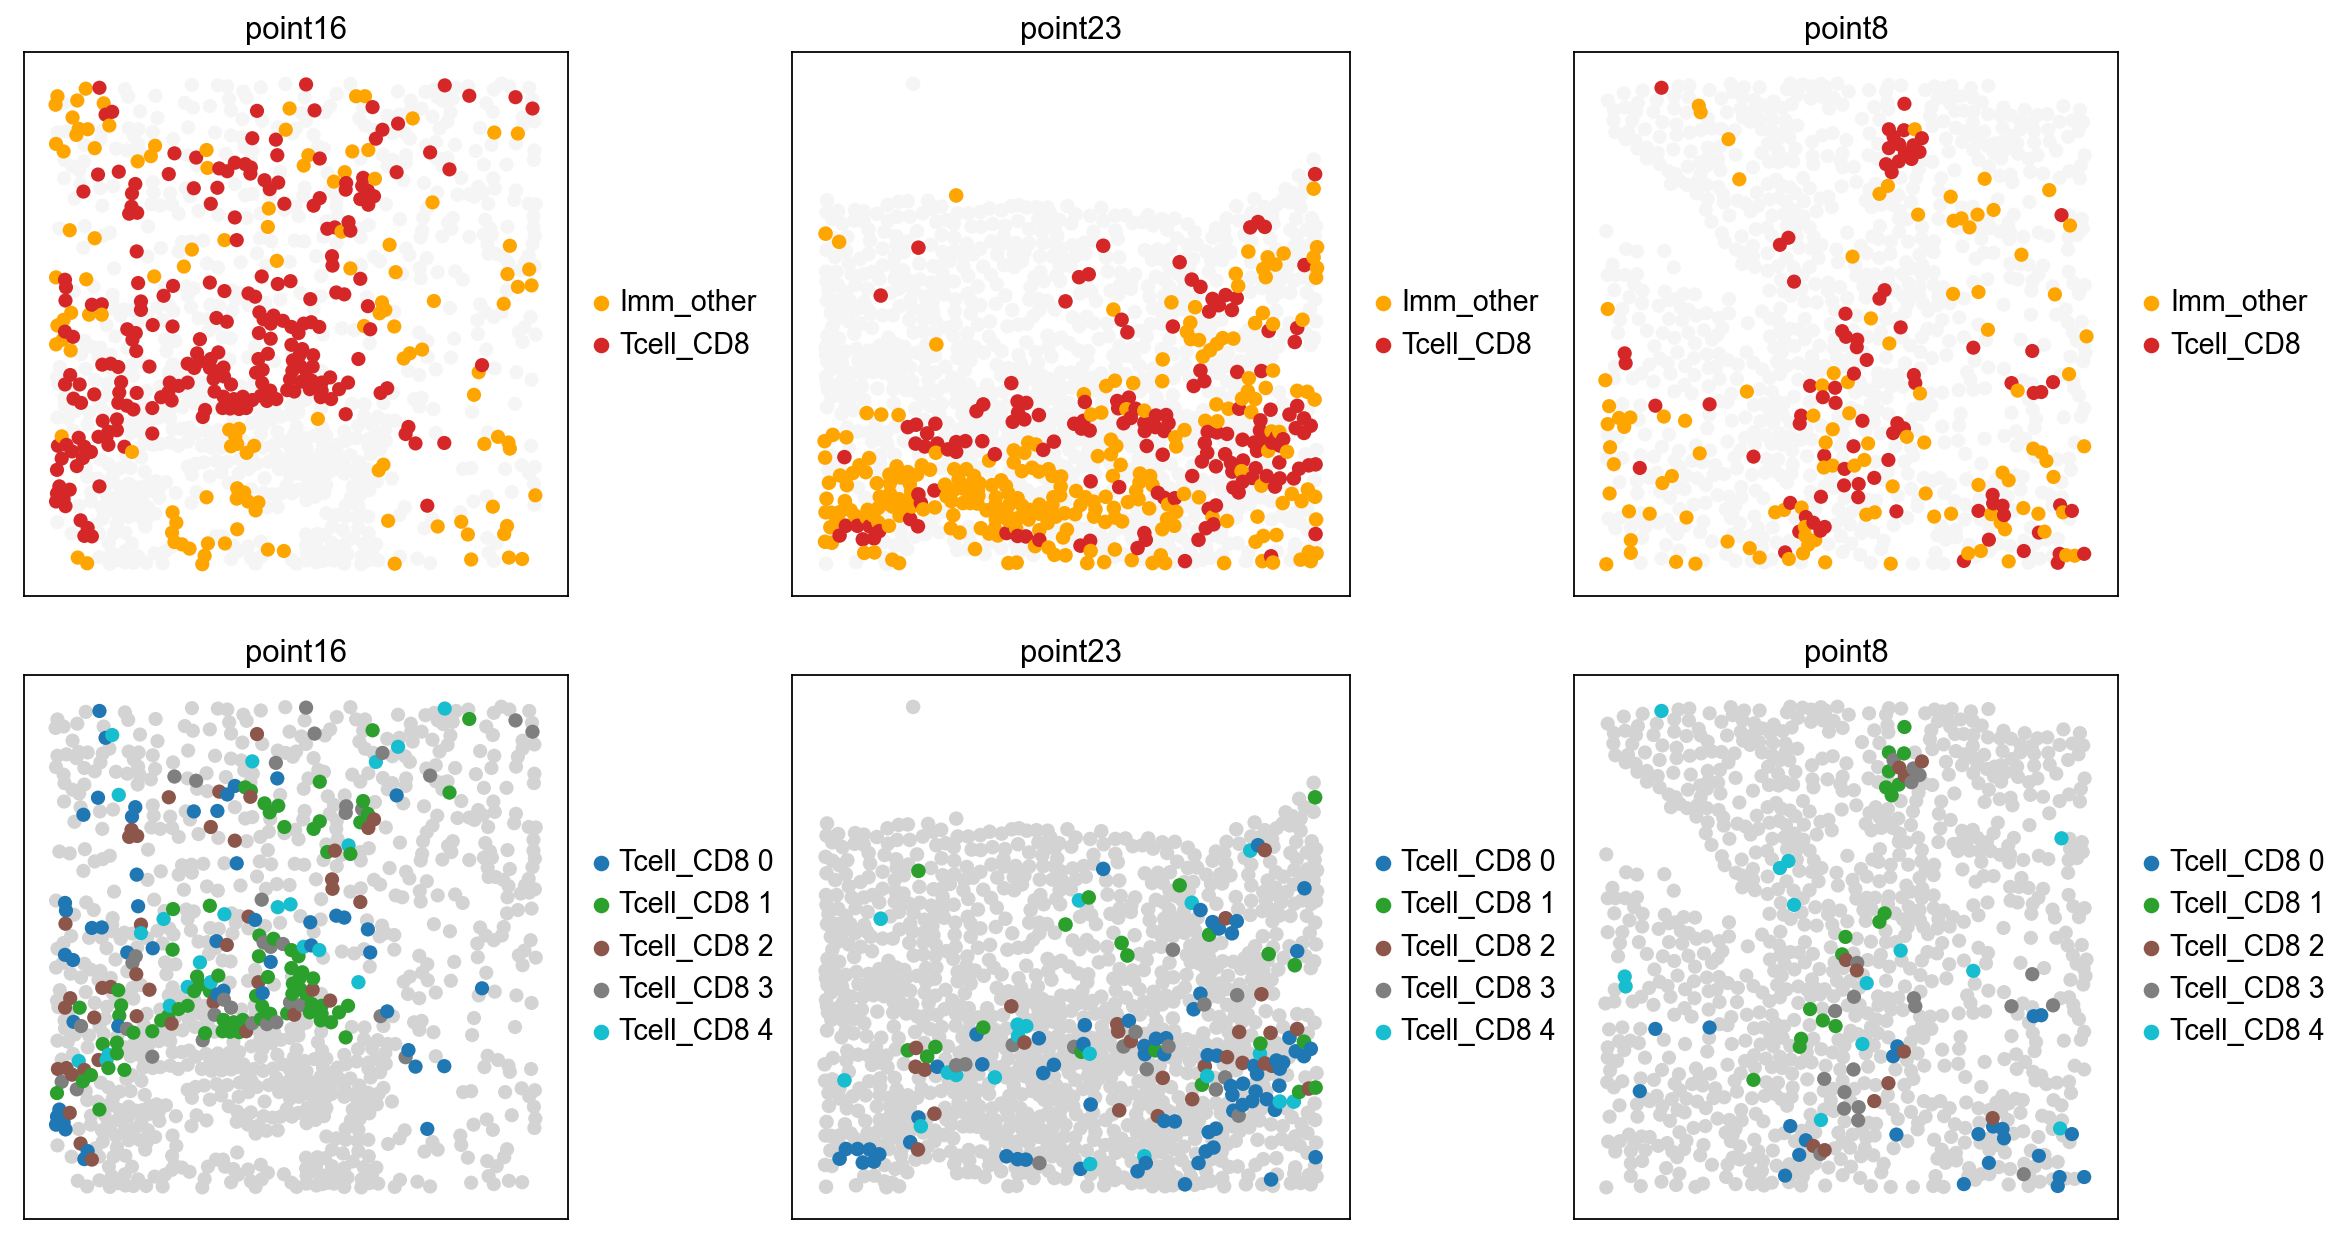

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
ax = ax.ravel()
for i, k in enumerate(['point16', 'point23', 'point8']):
    
    temp_adata = adata_img[adata_img.obs['library_id'] == k].copy()
    
    sc.pl.spatial(
        temp_adata,
        spot_size=30,
        ax=ax[i],
        show=False,
        na_color='whitesmoke',
        title=''
    )
    sc.pl.spatial(
        temp_adata[temp_adata.obs.Cluster.isin(['Imm_other', 'Tcell_CD8'])].copy(),
        color='Cluster',
        spot_size=30,
        ax=ax[i],
        show=False,
        title=k,
        palette={'Imm_other': 'orange', 'Tcell_CD8': '#d62728'}
    )
    
    sc.pl.spatial(
        adata_img[adata_img.obs.library_id == k].copy(),
        spot_size=30,
        ax=ax[i+3],
        show=False,
        title=''
    )
    sc.pl.spatial(
        adata[adata.obs.library_id == k].copy(),
        color='Tcell_CD8 substates',
        spot_size=30,
        ax=ax[i+3],
        show=False,
        title=k,
        palette='tab10'
    )
    
    ax[i].invert_yaxis()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i+3].invert_yaxis()
    ax[i+3].set_xlabel('')
    ax[i+3].set_ylabel('')
plt.tight_layout()
plt.show()

**Tasks 4**: Pick a cell type in your dataset for which you want to investigate the neighborhood structure. Is there an enrichment between different cell types?

## Type coupling analysis

As a next step, we can perform a type coupling analysis on the dataset and compute sender and receiver effects based on a Wald test on the parameters learned by the linear NCEM. For this analysis step NCEM uses the full data set and it is optimized with ordinary least squares.

The coupling is between a sender and receiver cell is then defined as the euclidean norm of significant coefficients that cprrespond to the specific sender-receiver interaction term in the linear NCEM.

In [18]:
ncem.get_sender_receiver_effects()

2022-08-29 09:35:47.799746: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [00:03<00:00, 108.18it/s]


using ols parameters.
calculating inv fim.


We can now visualize the putative sender-receiver interactions extracted in NCEM. 


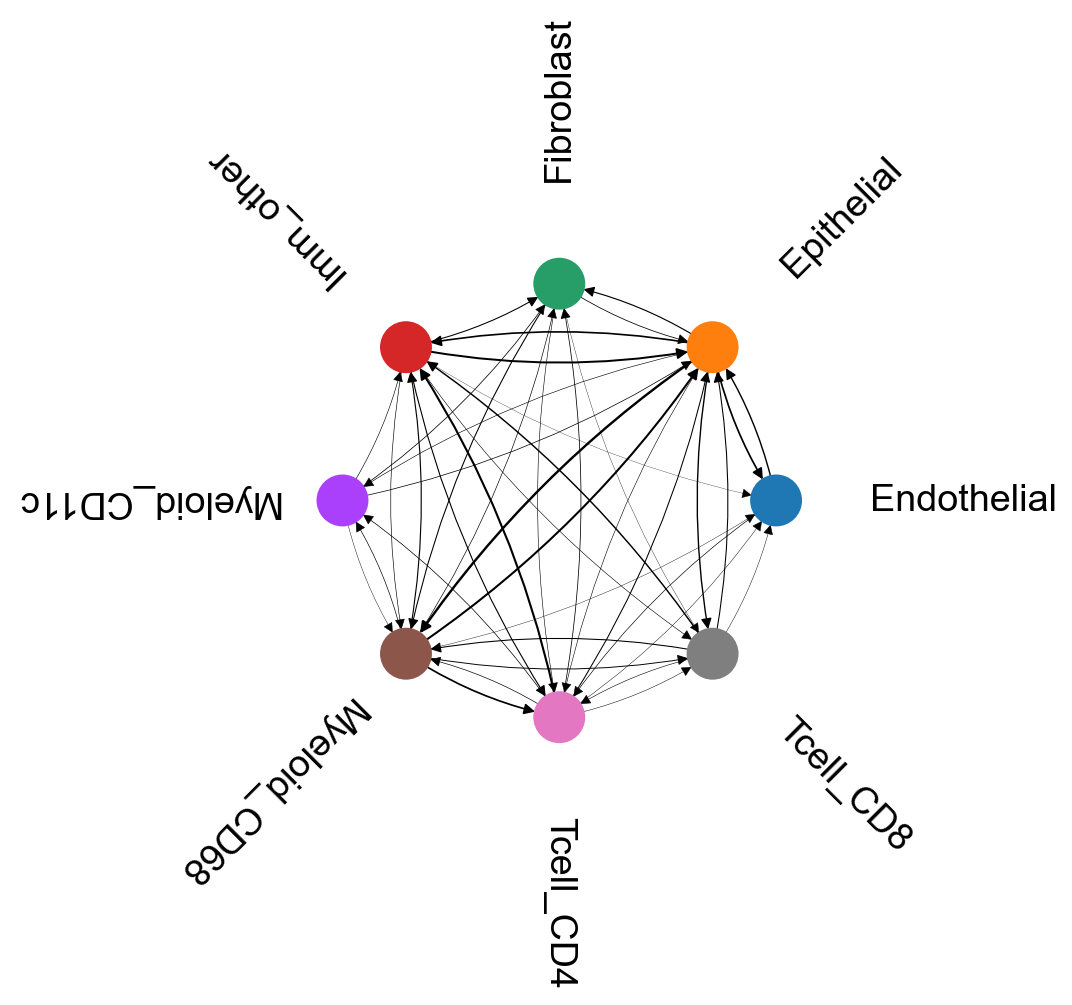

In [19]:
type_coupling = ncem.type_coupling_analysis_circular(
    edge_attr='magnitude', figsize=(9,8), text_space=1.78
)

In most cases, it is reasonable to filter the edges shown in the plot to only focus on the most important ones in terms of number of differentially expressed genes. The dataset measured 36 features, so we only want to visualize interactions with at least 10 differentially expressed genes. 

We can inspect that there is a sender-receiver dependency between (malignant) epithelial cells and CD 8 T cells which was also descibed by Hartmann et al. In this plot, the arrow thickness descibes the strength of directional dependencies between cell types as the magnitude of the corresponding coefficient vector.

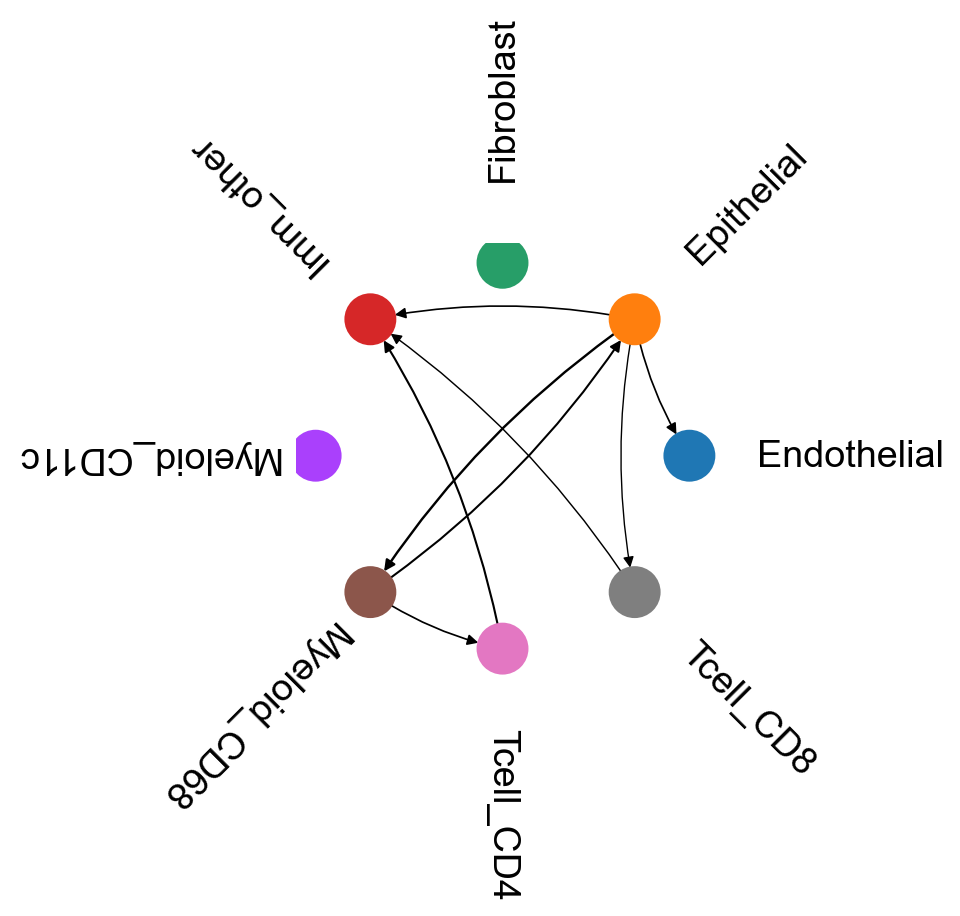

In [20]:
type_coupling = ncem.type_coupling_analysis_circular(
    edge_attr='magnitude', figsize=(9,8), de_genes_threshold=10, text_space=1.78
)

Alternatively, we can also visualize the number of differentially expressed genes. 

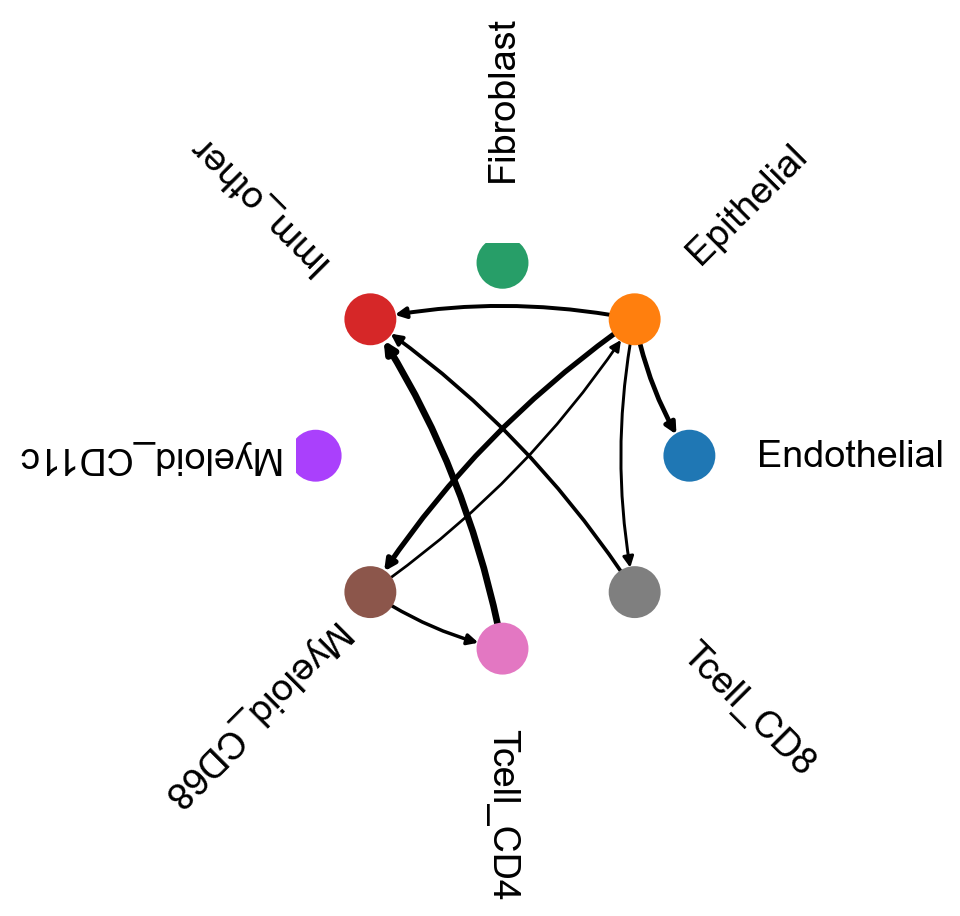

In [21]:
type_coupling = ncem.type_coupling_analysis_circular(
    edge_attr='de_genes', figsize=(9,8), de_genes_threshold=10, text_space=1.78
)

**Task 5**: Run the type-coupling analysis for your dataset. Do you find significant sender-receiver interactions?

## Putative sender-receiver dependencies

We can now dissected these couplings based on the gene-wise effects of one particular interaction. We will run this analysis on the sender cell type epithelial and the receiver cell type CD8 T cell. 

“Sender effect” analysis heatmap for CD 8 T cells. Shown is the estimated log fold change that the sender cell type on the y-axis induces in the gene on the x axis in receiving CD8 T cells. NCEM correctly identifies genes and proteins that play roles in T-cell activation, regulation of T-cell antigen receptor signalling and immune response.



In [22]:
effect_df = ncem.sender_receiver_values(sender='Epithelial', receiver='Tcell_CD8')

In [23]:
effect_df

,mean expression,pvalue,qvalue,fold change,-log 10 qvalue
ASCT2,-0.048295,5.922355e-01,0.821335,0.009340,0.085480
ATP5A,-0.026972,1.696351e-03,0.017874,-0.053788,1.747784
CD11c,0.034839,7.728931e-01,0.916300,0.005352,0.037963
CD14,0.048974,2.402927e-03,0.022712,0.057011,1.643751
CD3,0.270073,2.127130e-01,0.488354,0.027339,0.311265
CD31,0.027618,4.763245e-01,0.749433,0.013628,0.125267
CD36,-0.019434,1.345377e-02,0.081437,-0.035534,1.089176
CD39,0.018371,7.242285e-01,0.887146,0.006093,0.052005
CD4,0.064586,1.070127e-02,0.068999,0.049046,1.161156
CD45,0.185409,7.622856e-03,0.053401,0.051161,1.272449


In [24]:
gene_subset = effect_df[effect_df['qvalue'] <= 0.05].index

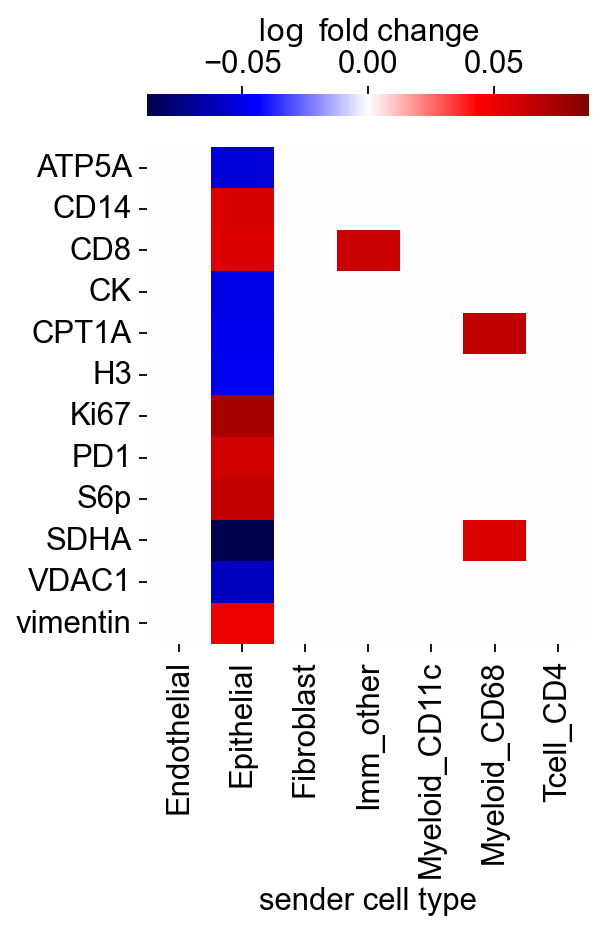

In [25]:
ncem.sender_effect(receiver='Tcell_CD8', gene_subset=list(gene_subset), figsize=(4,6))

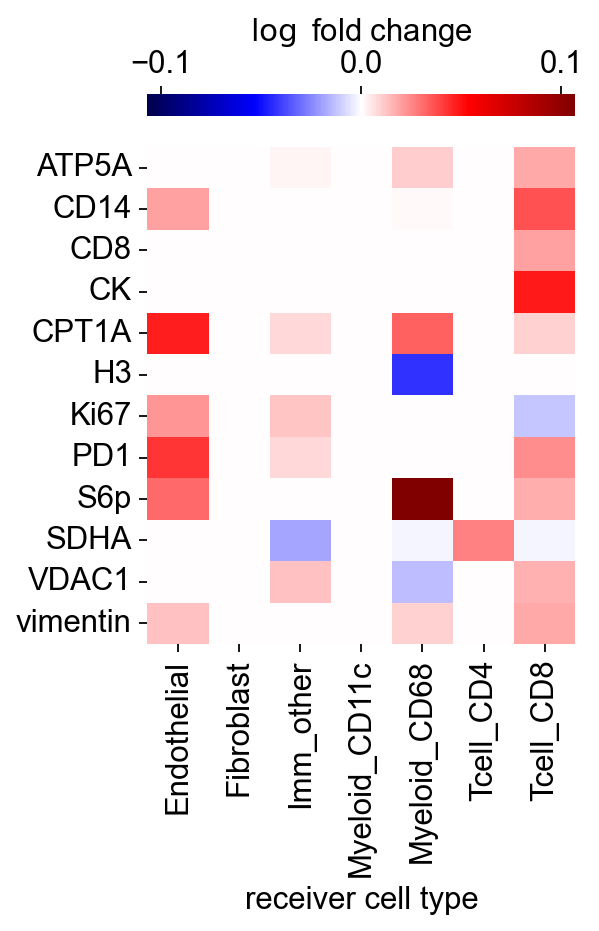

In [26]:
ncem.receiver_effect(
    sender='Epithelial', 
    figsize=(4,6),
    gene_subset=list(gene_subset)
)

This analysis contextualizes differential expression results of the CD8 Tcell – Epithelial cell axis.

Volcano plot of differentially expressed genes of Epithelial cells in the neighborhood of CD8 T cells.

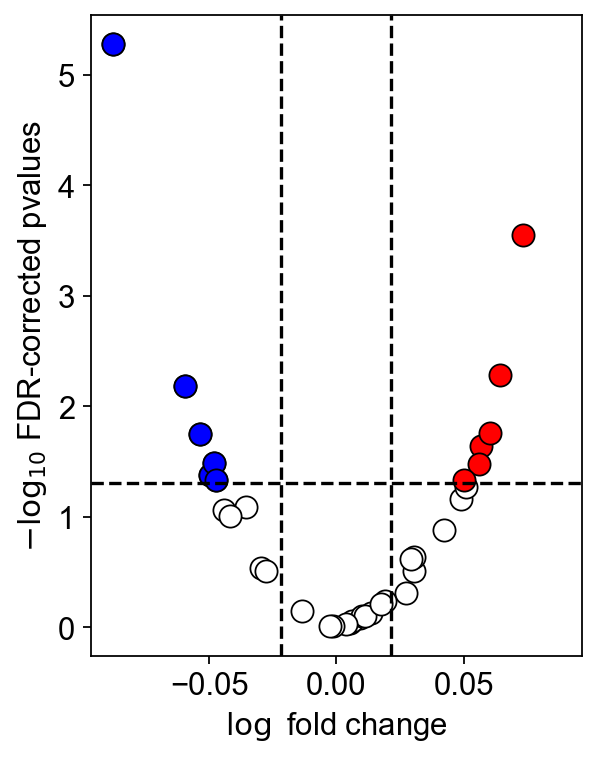

In [27]:
ncem.sender_receiver_effect_vulcanoplot(
    sender='Epithelial', receiver='Tcell_CD8', figsize=(4,5)
)

**Task 6**: Investigate the p-values and fold changes of important genes for one sender-receiver dependency. 

### Sender similarity analysis

“Sender similarity analysis” of all sender cell types with respect to other immune cell receivers. Shown is a clustered heatmap of Pearson correlation coefficients of the coefficient vectors of each sender type that corresponds to other immune cell receivers.

T cell clusters had a similar effect on other immune cells in a “sender similarity analysis”. This analysis helps to inspect the sender profile of different cells types in the dataset. We inspected in the full dataset that CD8 T cells and CD4 T cells had a similar sender profile on Epithelial cells, which demonstrates conservation of cell type identity in the sender profile. 

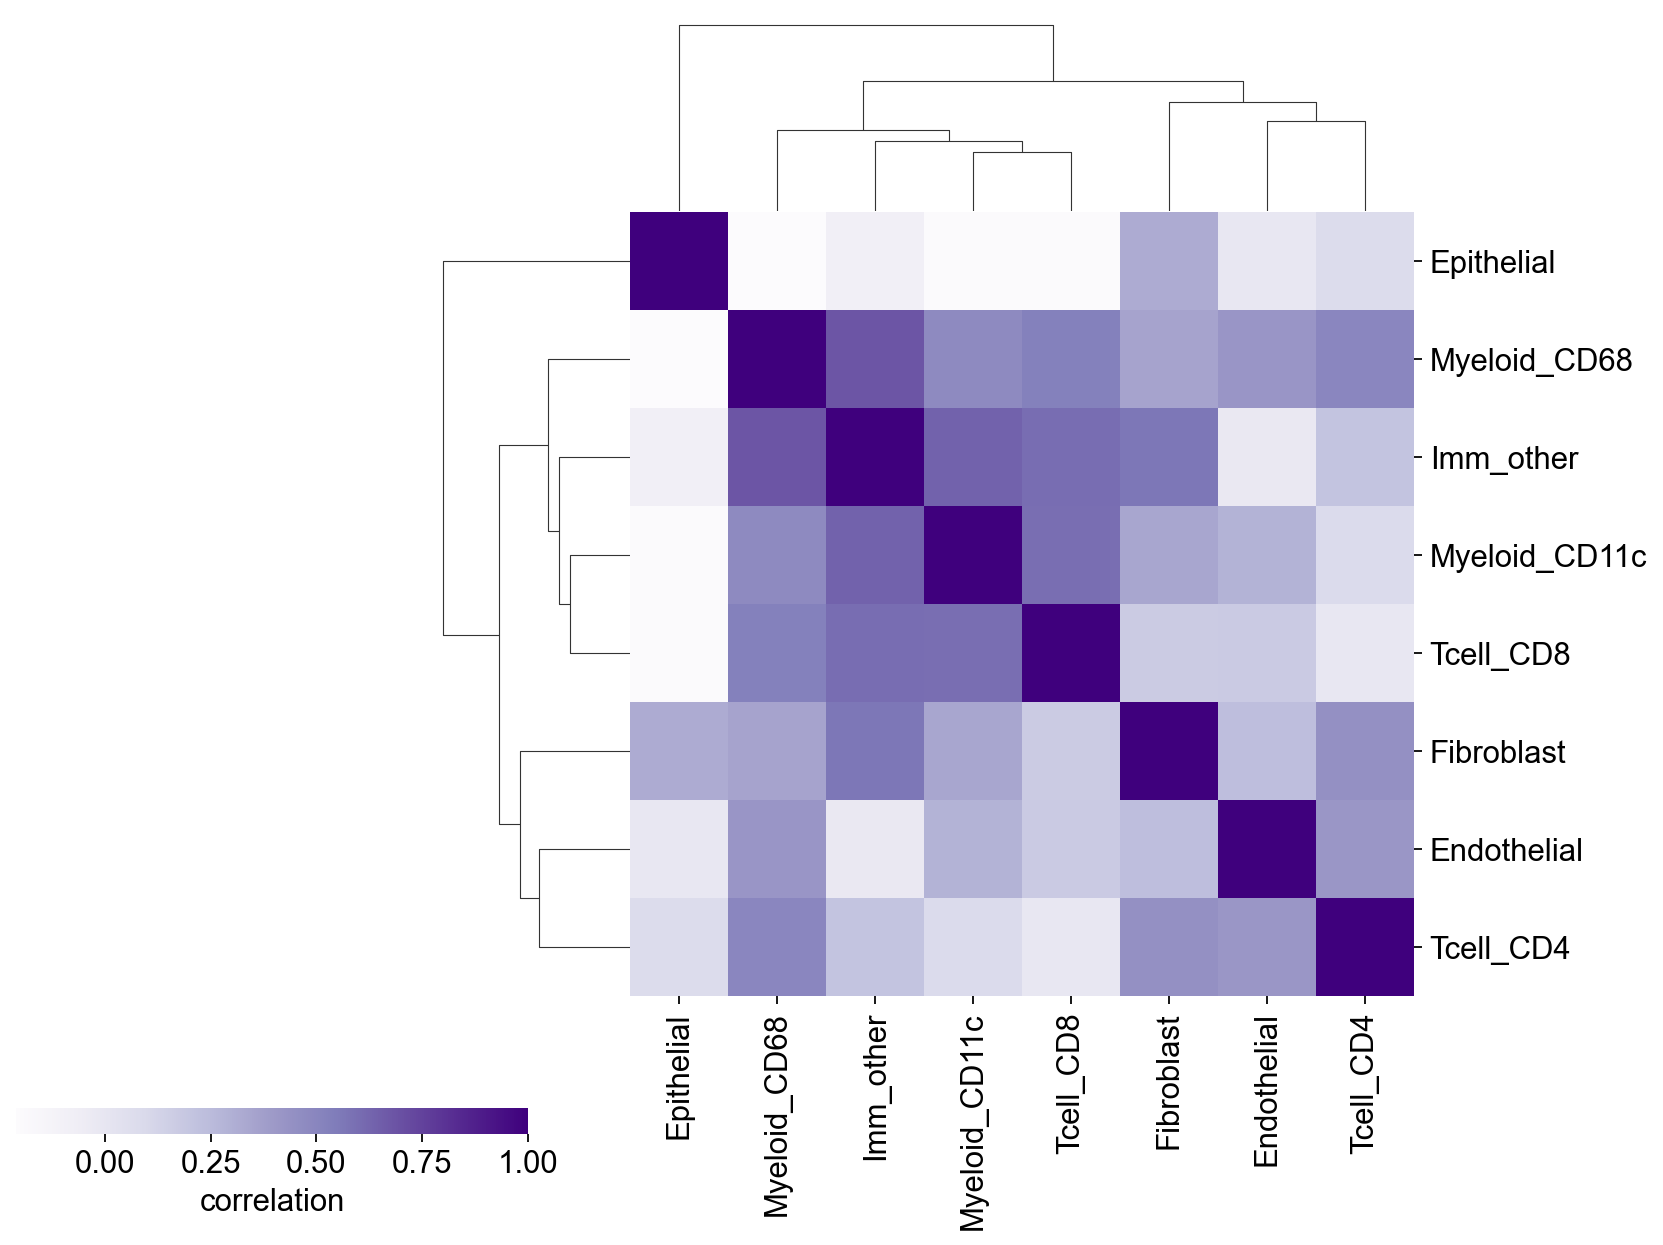

In [28]:
ncem.sender_similarity_analysis(receiver='Epithelial')